# TestGrid: exploring in-depth metadata


_Note: This notebook can be run and experimented with directly using the "ocp-ci-analysis" image at our [jupyterhub instance](https://jupyterhub-opf-jupyterhub.apps.cnv.massopen.cloud/hub/login) hosted on the MOC._  

This notebook explores metadata present at a Test level within the existing TestGrid data at [testgrid.k8s.io](testgrid.k8s.io).

For initial exploration of the Testgrid data visit [testgrid_EDA.ipynb](testgrid_EDA.ipyb).

In [1]:
import requests
import datetime as dt

from IPython.display import Image

**What is Testgrid?** According to the project's [readme](https://github.com/GoogleCloudPlatform/testgrid) it is a, "highly configurable, interactive dashboard for viewing your test results in a grid!" In other words, its an aggregation and visualization platform for CI data. Our hope is that this aggregation encodes some of the subject matter experts' knowledge, and will provide better initial features than going straight to the more complex underlying CI data artifacts [here](https://gcsweb-ci.apps.ci.l2s4.p1.openshiftapps.com/gcs/origin-ci-test/logs/). 

Lets look into the various metadata fields present on a test level within each job for the testgrid dataset.

To pull the desired json we can follow this syntax: 

`https://testgrid.k8s.io/{dashboard_name}/table?&show-stale-tests=&tab={job_name}`

Here we will get the data for 2 dashboard and jobs for further exploration as examples.

1. **dashboard** : "redhat-openshift-ocp-release-4.2-informing" ,
    **job** :  "release-openshift-origin-installer-e2e-aws-upgrade-rollback-4.1-to-4.2" 

2. **dashboard** : "jetstack-cert-manager-master" ,
    **job** : "ci-cert-manager-bazel" 

In [2]:
response = requests.get(
    "https://testgrid.k8s.io/redhat-openshift-ocp-release-4.2-informing/table? \
    &show-stale-tests=&tab=release-openshift-origin-installer-e2e-aws-upgrade-rollback-4.1-to-4.2"
)

In [3]:
response1 = requests.get(
    "https://testgrid.k8s.io/jetstack-cert-manager-master/table? \
    &show-stale-tests=&tab=ci-cert-manager-bazel"
)

`response` has all the fields expected by TestGrid's javascript client. It represents a grid of test results, with additional annotations for metadata.

The first thing we want to do is see what what keys we have in our detailed job data. Below we can see that there are a number of fields in this json.

In [4]:
for i in response.json().keys():
    print(i)

test-group-name
query
status
phase-timer
cached
summary
bugs
changelists
column_ids
custom-columns
column-header-names
groups
metrics
tests
row_ids
timestamps
clusters
test_id_map
test-metadata
stale-test-threshold
num-stale-tests
add-tabular-names-option
show-tabular-names
description
bug-component
code-search-path
open-test-template
file-bug-template
attach-bug-template
results-url-template
code-search-url-template
about-dashboard-url
open-bug-template
context-menu-template
results-text
latest-green
triage-enabled
notifications
overall-status


We will now explore each metadata within the json and try to understand the significance of the values it contains

The summary field is always empty, hence we will ignore that here.

### test-group-name

In [5]:
print(response.json()["test-group-name"])

releaseopenshiftorigininstallere2eawsupgraderollback41to42


As we can see above, the`test-group-name` is a string value which contains the particular job name for which all the tests are executed. 

### query

In [6]:
print(response.json()["query"])

origin-ci-test/logs/release-openshift-origin-installer-e2e-aws-upgrade-rollback-4.1-to-4.2


The above `query` is a string value which contains the `gcs_prefix` pertaining to the job. The `gcs_prefix` is the path to the test data stored in gcs (some-bucket/some/optional/path). The metadata can also be seen [here](https://testgrid.k8s.io/q/config/redhat-openshift-ocp-release-4.2-informing/release-openshift-origin-installer-e2e-aws-upgrade-rollback-4.1-to-4.2) and is documented [here](https://github.com/GoogleCloudPlatform/testgrid/blob/master/pb/config/config.proto).

### status

In [7]:
print(response.json()["status"])

Served 1207 results in 0.12 seconds


The `status` aggregates the tests for which a result - Pass, Fail, Flaky, Running was displayed and the time taken to serve the status. The time taken is calculated by aggregating times for different phases, which are further broken down in `phase-timer`. The status line is displayed on the Status bar for the job.

### phase-timer

In [8]:
print(response.json()["phase-timer"])

{'phases': ['config load', 'cache peek (stale)', 'state fetch', 'state decompress', 'state unmarshal', 'table creation', 'table serialize (gob+snappy: 13KiB)', 'table querying'], 'delta': [3.3446e-05, 0.024783251, 0.065446678, 0.000407352, 0.000606137, 0.000143904, 0.001007845, 0.028168015], 'total': 0.120596628}


The `phase-timer` is a dictionary that contains the duration of each update cycle and stores the time taken for different phases. The aggregate time is used to populate the `status` displayed on the status bar of the job.

### cached

In [9]:
print(response.json()["cached"])

False


`cached` holds a True or False value to determine if the response is loaded from a cache.

### bugs

In [10]:
print(response.json()["bugs"])

{}


`bugs` is an empty dictionary here, but it should contain any linked bugs created for the job

### changelists

In [11]:
print(response.json()["changelists"])

['1369994168893444096', '1369811862551531520', '1369630643398381568', '1369449096883998720', '1369267681374507008', '1369086139733905408', '1368904775671746560', '1368723410221273088', '1368542014391455744', '1368360542443409408', '1368179004518961152', '1367997486991413248', '1367816194010124288', '1367634626750713856', '1367453420490854400', '1367271859506122752', '1367090290040508416', '1366908795321585664', '1366727302242635776', '1366545773512101888', '1366364084542377984', '1366182730919841792', '1366001409320816640', '1365820080784412672', '1365638694890901504', '1365457253460611072', '1365275795735449600', '1365094202605572096', '1364912643088846848', '1364731000319381504']


`changelists` list consisting of IDs for each test within a job. The `changelists` can be used in a URL template to visit the Prow Dashboard after clicking on a cell such as `https://prow.k8s.io/view/gcs/<gcs_prefix>/<changelists>` for eg. https://prow.ci.openshift.org/view/gcs/origin-ci-test/logs/release-openshift-origin-installer-e2e-aws-upgrade-rollback-4.1-to-4.2/1365457253460611072

### column_ids

In [12]:
print(response.json()["column_ids"])

['\ue0001369994168893444096', '\ue0001369811862551531520', '\ue0001369630643398381568', '\ue0001369449096883998720', '\ue0001369267681374507008', '\ue0001369086139733905408', '\ue0001368904775671746560', '\ue0001368723410221273088', '\ue0001368542014391455744', '\ue0001368360542443409408', '\ue0001368179004518961152', '\ue0001367997486991413248', '\ue0001367816194010124288', '\ue0001367634626750713856', '\ue0001367453420490854400', '\ue0001367271859506122752', '\ue0001367090290040508416', '\ue0001366908795321585664', '\ue0001366727302242635776', '\ue0001366545773512101888', '\ue0001366364084542377984', '\ue0001366182730919841792', '\ue0001366001409320816640', '\ue0001365820080784412672', '\ue0001365638694890901504', '\ue0001365457253460611072', '\ue0001365275795735449600', '\ue0001365094202605572096', '\ue0001364912643088846848', '\ue0001364731000319381504']


In [13]:
len(response.json()["column_ids"])

30

In [14]:
print("\ue0001369630643398381568")

î€€1369630643398381568


In [15]:
ord("\ue000")

57344

`column_ids` are timestamps from `changelists` preceded by a unicode character `\ue000`.

### custom-columns

In [16]:
print(response.json()["custom-columns"])

[['missing', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1'], ['missing', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']]


In [17]:
print(response1.json()["custom-columns"])

[['f40ffc87c', 'f40ffc87c', 'f40ffc87c', 'f40ffc87c', '9f343ec58', '9f343ec58', '9f343ec58', '9f343ec58', '9f343ec58', '9f343ec58', '9f343ec58', '9f343ec58', '9f343ec58', '9f343ec58', '9f343ec58', '9f343ec58', 'c01603dd3', 'c2634d353', 'c2634d353', 'c2634d353', 'c2634d353', 'c2634d353', 'c2634d353', 'c2634d353', 'c2634d353', 'c2634d353', 'c2634d353', 'c2634d353', 'c2634d353', 'c2634d353', 'c2634d353', 'c2634d353', '07964edea', '07964edea', '07964edea', '07964edea', '07964edea', '07964edea', '07964edea', '07964edea', '07964edea', '07964edea', '07964edea', '07964edea', '07964edea', '07964edea', '07964edea', '07964edea', '07964edea', '07964edea', '07964edea', '07964edea', '07964edea', '07964edea', '07964edea', '07964edea', '07964edea', '07964edea', '07964edea', '07964edea', '07964edea', '07964edea', '07964edea', '07964edea', '07964edea', '75a46ff90', 'deb55110a', 'deb55110a', 'deb55110a', 'deb55110a', 'deb55110a', 'deb55110a', 'deb55110a', 'deb55110a', 'deb55110a', '28fc97699', '28fc97699

For the first dashboard, `custom-columns` did not contain any values, but for the second dashboard, we see that `custom-columns` is nothing but a list of column headers with commit-ids for each test.

For example, as we see below '9f343ec58' is common header and commit-id for the first tests.

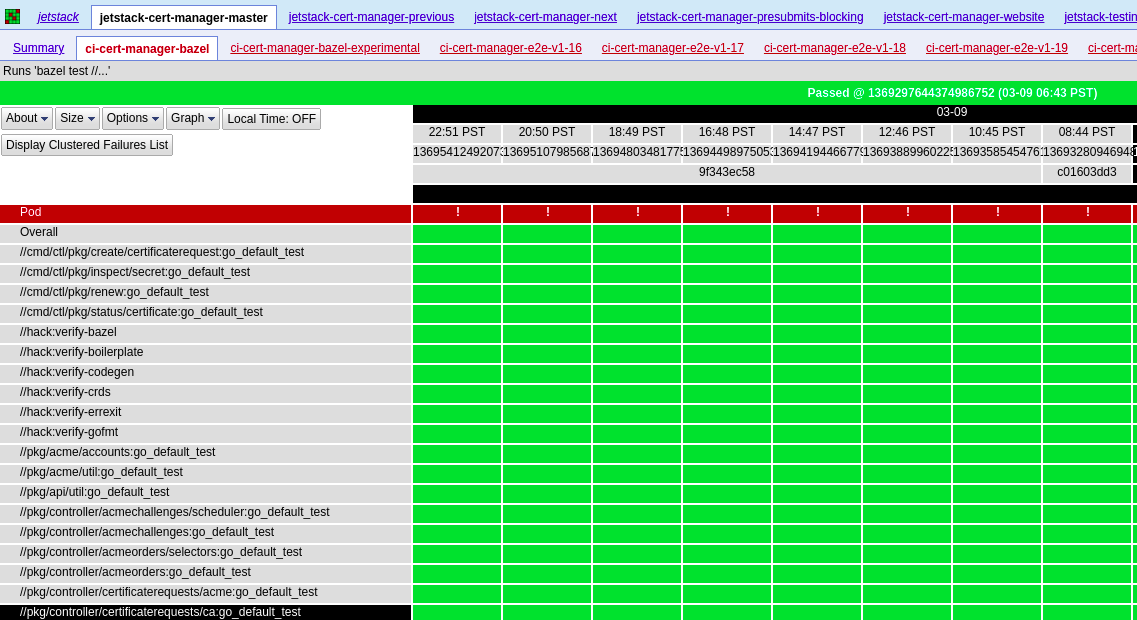

In [18]:
Image(filename="../../../docs/assets/images/metadata-3.png")

In [19]:
len(response.json()["custom-columns"][0])

30

### column-header-names

In [20]:
print(response.json()["column-header-names"])

['Date', 'Time', 'Build Number', 'Commit', 'Infra-Commit']


This is not relevant to our current dashboards which we are looking at, since the values for these column headers are vacant as seen below.

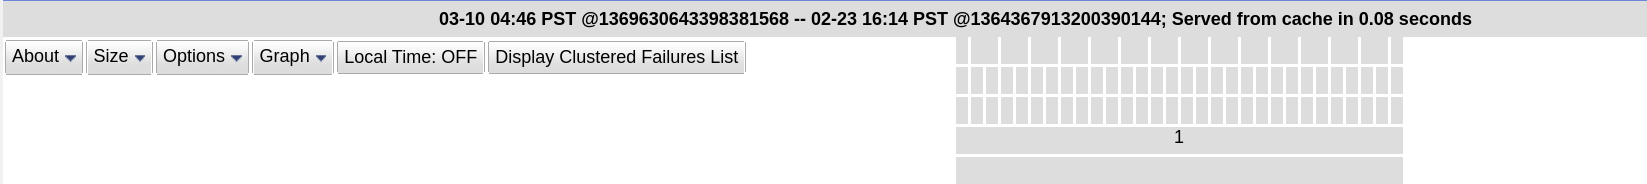

In [21]:
Image(filename="../../../docs/assets/images/metadata-1.png")

However, in other dashboards like https://testgrid.k8s.io/jetstack-cert-manager-master#ci-cert-manager-bazel, these consist of 'Date', 'Time', 'Build Number', 'Commit', 'Infra-Commit' for each Test. 


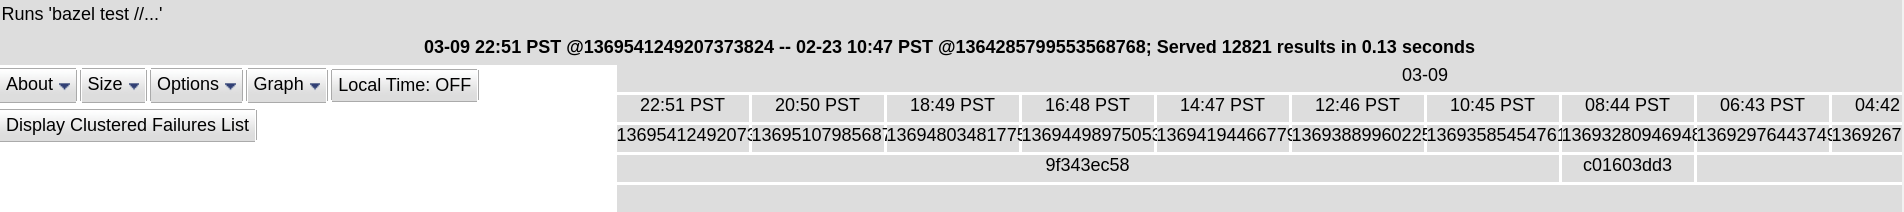

In [22]:
Image(filename="../../../docs/assets/images/metadata-2.png")

### groups

In [23]:
print(response1.json()["groups"])

['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


Not sure what this means

### metrics

In [24]:
print(response1.json()["metrics"])

['test-duration-minutes']


`metrics` is a list consisting of string labels for viewing additional metrics such as `test-duration-minutes`

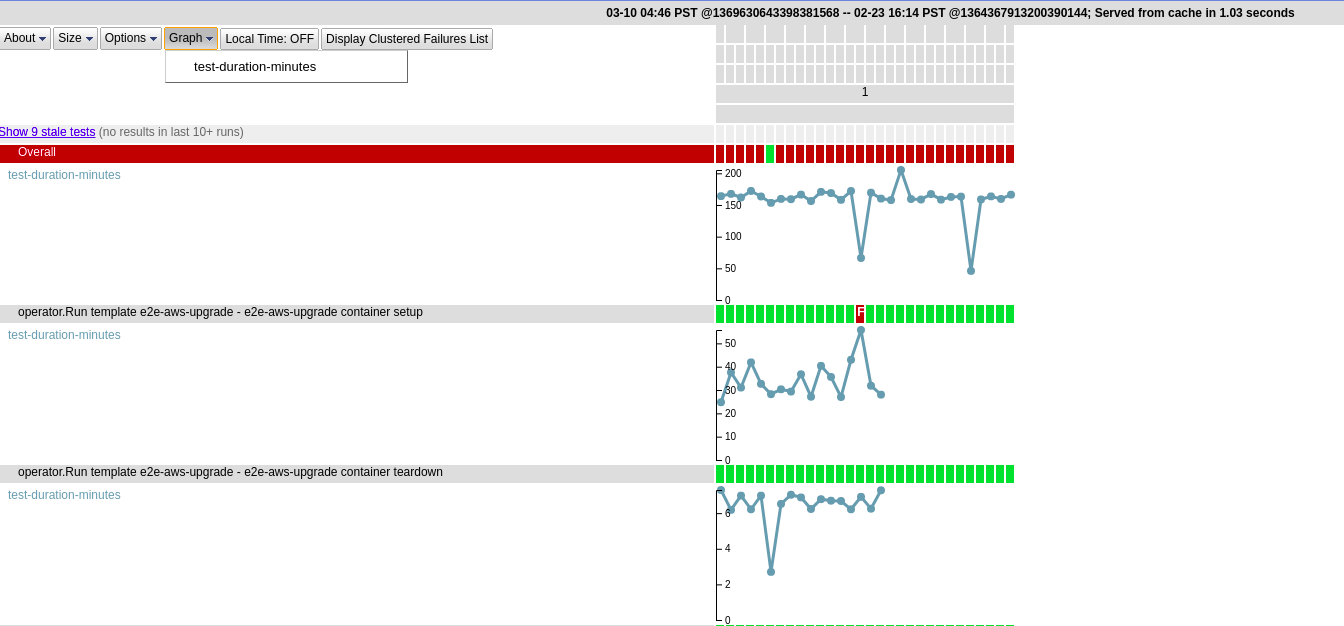

In [25]:
Image(filename="../../../docs/assets/images/metadata-4.png")

### row_ids

In [26]:
print(response.json()["row_ids"])

['Overall', 'Pod', 'Operator results.operator conditions authentication', 'Operator results.operator conditions cloud-credential', 'Operator results.operator conditions monitoring', 'Operator results.operator conditions network', 'Operator results.operator conditions openshift-samples', 'openshift-tests.Monitor cluster while tests execute', 'openshift-tests.[Disruptive] Cluster upgrade should maintain a functioning cluster [Feature:ClusterUpgrade] [Suite:openshift] [Serial]', 'operator.Run template e2e-aws-upgrade - e2e-aws-upgrade container test', 'Operator results.operator conditions operator-lifecycle-manager-packageserver', 'Operator results.operator conditions service-ca', 'Operator results.operator conditions image-registry', 'Operator results.operator conditions dns', 'Operator results.operator conditions machine-config', 'Operator results.operator conditions console', 'Operator results.operator conditions openshift-apiserver', 'operator.Run template e2e-aws-upgrade - e2e-aws-up

`row_ids` is a list consisting of all the various tests executed for the job `release-openshift-origin-installer-e2e-aws-upgrade-rollback-4.1-to-4.2`. Each job also has an `Overall` row which summarises all the test runs for the job.

In [27]:
len(response.json()["row_ids"])

52

We see that `52` tests were run for the job `release-openshift-origin-installer-e2e-aws-upgrade-rollback-4.1-to-4.2` in the dashboard `redhat-openshift-ocp-release-4.2-informing`

In [28]:
print(response1.json()["row_ids"])

['Pod', 'Overall', '//cmd/ctl/pkg/create/certificaterequest:go_default_test', '//cmd/ctl/pkg/inspect/secret:go_default_test', '//cmd/ctl/pkg/renew:go_default_test', '//cmd/ctl/pkg/status/certificate:go_default_test', '//hack:verify-bazel', '//hack:verify-boilerplate', '//hack:verify-codegen', '//hack:verify-crds', '//hack:verify-errexit', '//hack:verify-gofmt', '//pkg/acme/accounts:go_default_test', '//pkg/acme/util:go_default_test', '//pkg/api/util:go_default_test', '//pkg/controller/acmechallenges/scheduler:go_default_test', '//pkg/controller/acmechallenges:go_default_test', '//pkg/controller/acmeorders/selectors:go_default_test', '//pkg/controller/acmeorders:go_default_test', '//pkg/controller/certificaterequests/acme:go_default_test', '//pkg/controller/certificaterequests/ca:go_default_test', '//pkg/controller/certificaterequests/selfsigned:go_default_test', '//pkg/controller/certificaterequests/util:go_default_test', '//pkg/controller/certificaterequests/vault:go_default_test', '/

In [29]:
len(response1.json()["row_ids"])

76

Similary, we see the various tests executed for the job `ci-cert-manager-bazel` in dashboard `jetstack-cert-manager-master`.

### timestamps

In [30]:
print(response.json()["timestamps"])

[1615467683000, 1615423576000, 1615380370000, 1615337085000, 1615293832000, 1615250550000, 1615207308000, 1615164068000, 1615120820000, 1615077555000, 1615034271000, 1614990999000, 1614947770000, 1614904482000, 1614861279000, 1614817991000, 1614774702000, 1614731430000, 1614688159000, 1614644879000, 1614601573000, 1614558326000, 1614515097000, 1614471864000, 1614428617000, 1614385358000, 1614342104000, 1614298805000, 1614255516000, 1614212210000]


`timestamps` returns the timestamp of when the test runs were executed.

In [31]:
len(response.json()["timestamps"])

30

In [32]:
t1 = response.json()["timestamps"]
dates = [dt.datetime.fromtimestamp(item / 1000).strftime("%d-%m-%y") for item in t1]
dates

['11-03-21',
 '10-03-21',
 '10-03-21',
 '09-03-21',
 '09-03-21',
 '08-03-21',
 '08-03-21',
 '07-03-21',
 '07-03-21',
 '06-03-21',
 '06-03-21',
 '05-03-21',
 '05-03-21',
 '04-03-21',
 '04-03-21',
 '03-03-21',
 '03-03-21',
 '02-03-21',
 '02-03-21',
 '01-03-21',
 '01-03-21',
 '28-02-21',
 '28-02-21',
 '27-02-21',
 '27-02-21',
 '26-02-21',
 '26-02-21',
 '25-02-21',
 '25-02-21',
 '24-02-21']

We can convert them to datetime format for further analysis.

In [33]:
print(response1.json()["timestamps"])

[1615489068000, 1615481837000, 1615474638000, 1615467437000, 1615460238000, 1615453038000, 1615438637000, 1615431437000, 1615424177000, 1615359061000, 1615351801000, 1615344541000, 1615337283000, 1615330024000, 1615322760000, 1615315502000, 1615308246000, 1615300982000, 1615293730000, 1615286578000, 1615279310000, 1615272050000, 1615264852000, 1615257591000, 1615250331000, 1615243131000, 1615235932000, 1615228732000, 1615221531000, 1615214272000, 1615207072000, 1615199810000, 1615192620000, 1615185361000, 1615178103000, 1615170840000, 1615163580000, 1615156321000, 1615149060000, 1615141800000, 1615134572000, 1615127312000, 1615120051000, 1615112789000, 1615105569000, 1615098308000, 1615091050000, 1615083792000, 1615076528000, 1615069269000, 1615062029000, 1615054771000, 1615047514000, 1615040251000, 1615032990000, 1615025731000, 1615018470000, 1615011211000, 1615003951000, 1614996691000, 1614989431000, 1614982172000, 1614974924000, 1614967665000, 1614960398000, 1614953138000, 161494587

In [34]:
len(response1.json()["timestamps"])

170

### clusters

In [35]:
print(response.json()["clusters"])

[]


In [36]:
print(response1.json()["clusters"])

[]


Not very sure what `clusters` should return. According to: https://github.com/GoogleCloudPlatform/testgrid/blob/ce1b1405fc889f371fa047ac03adfab23447c804/README.md#clustered-failures, `clusters` should probably return the clustered failure tests. However, this does not seem to be the case since for `release-openshift-origin-installer-e2e-aws-upgrade-rollback-4.1-to-4.2` in the dashboard `redhat-openshift-ocp-release-4.2-informing`, we see that when we filter the dashboard tab to "Display Clustered Failure Tests" it returns the following:

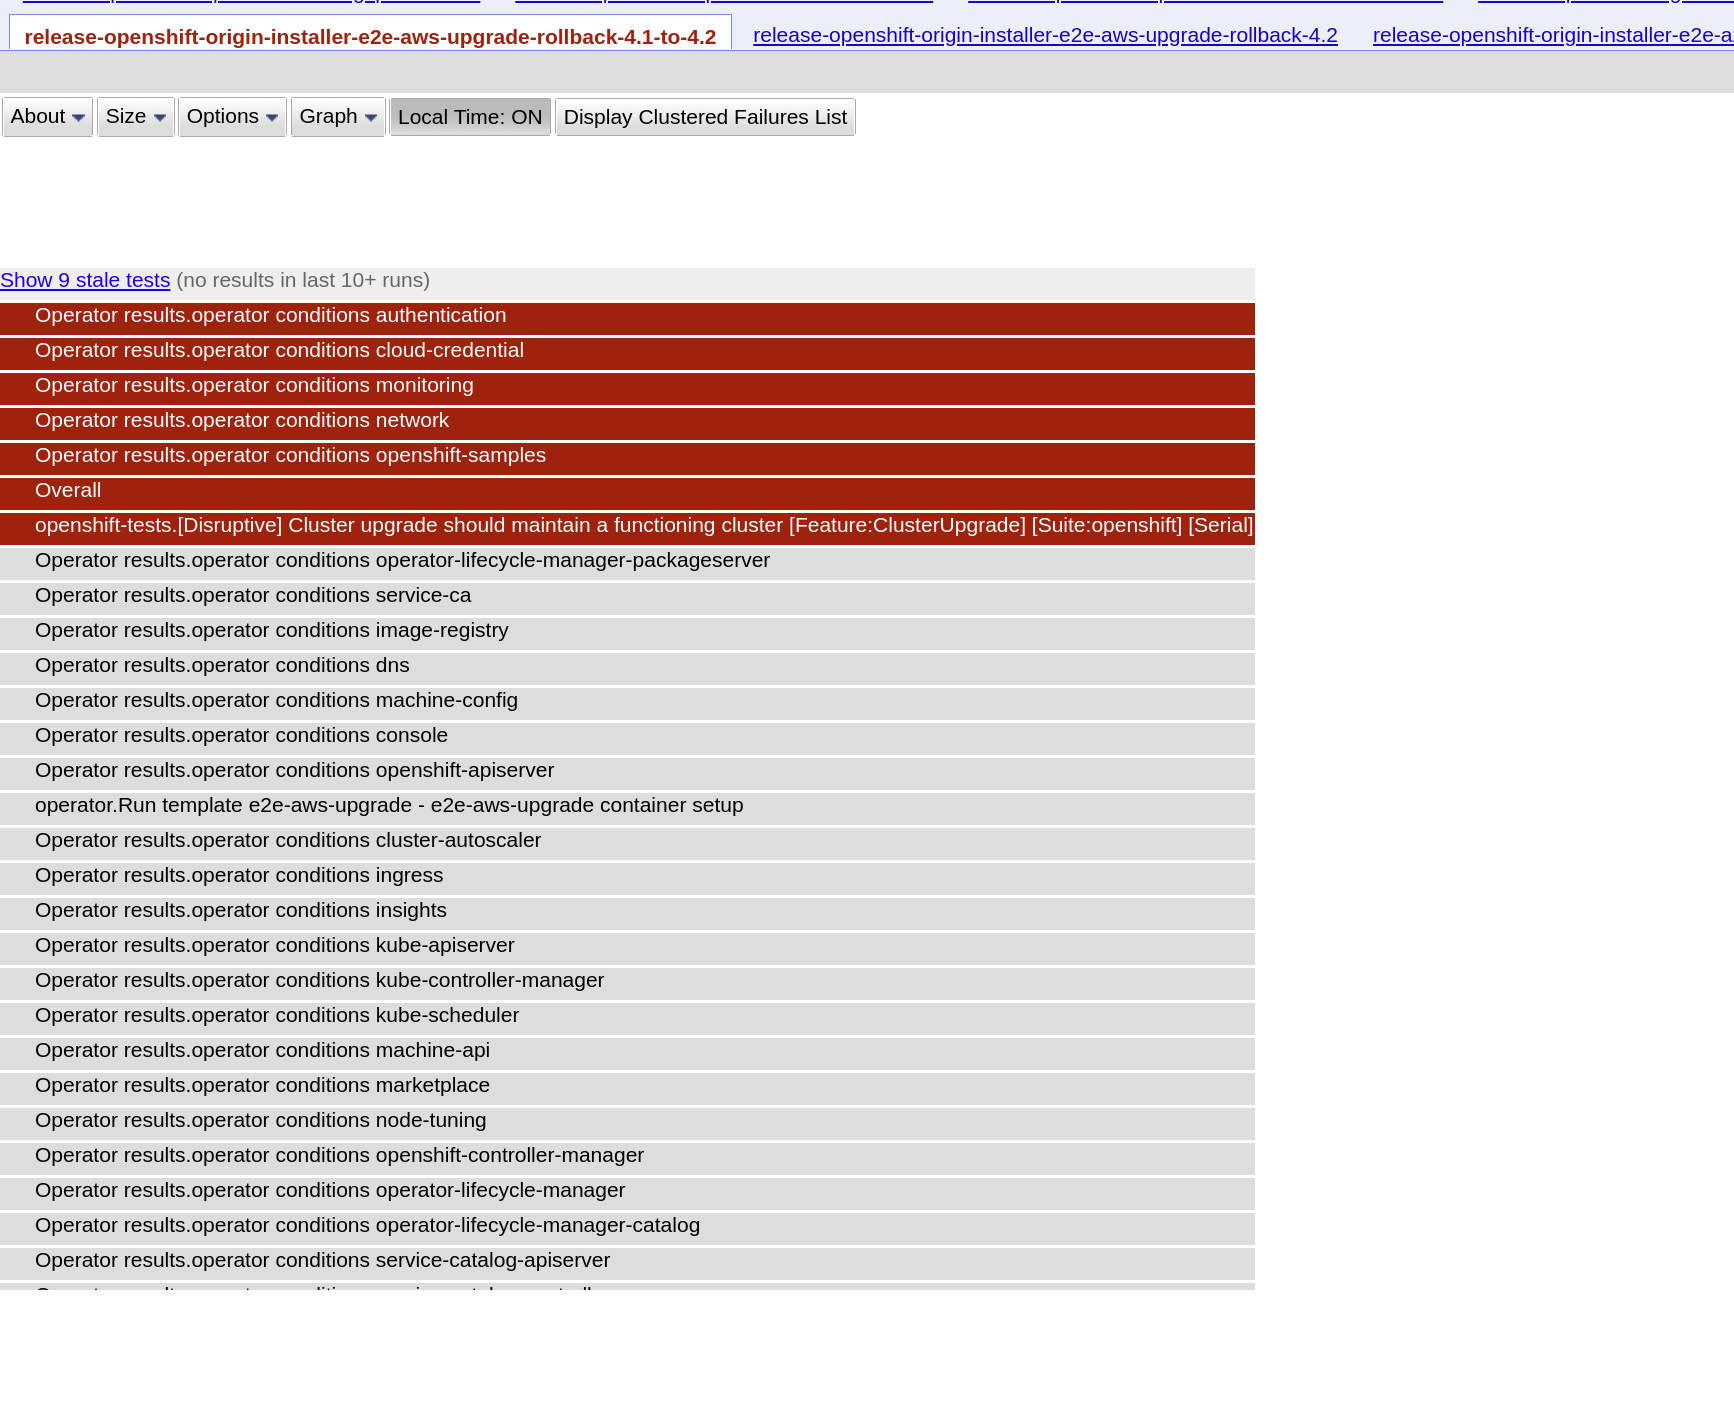

In [37]:
Image(filename="../../../docs/assets/images/testgrid_02.png")

### test_id_map

In [38]:
print(response.json()["test_id_map"])

None


In [39]:
print(response1.json()["test_id_map"])

None


This seems to be a lookup map for shortening long test IDs in each row: https://github.com/GoogleCloudPlatform/testgrid/blob/master/pb/response/types.proto#L133

### test-metadata

In [40]:
print(response.json()["test-metadata"])

{}


In [41]:
print(response1.json()["test-metadata"])

{}


### stale-test-threshold

In [42]:
print(response.json()["stale-test-threshold"])

10


In [43]:
print(response1.json()["stale-test-threshold"])

10


`stale-test-threshold` probably indicates the threshold for the number of tests that can be stale for a particular job. For both the jobs in this example, 10 is the maximum number of tests that can be "stale".

### num-stale-tests

In [44]:
print(response.json()["num-stale-tests"])

9


We see that for job`release-openshift-origin-installer-e2e-aws-upgrade-rollback-4.1-to-4.2` in the dashboard `redhat-openshift-ocp-release-4.2-informing`, the number of stale tests is `9` which is below the defined threshold of 10.

In [45]:
print(response1.json()["num-stale-tests"])

0


Similary, for the job `ci-cert-manager-bazel` in dashboard `jetstack-cert-manager-master`, the number of stale tests were `0` which is well below the defined threshold of 10.

### add-tabular-name-option

In [46]:
print(response.json()["add-tabular-names-option"])

False


In [47]:
print(response1.json()["add-tabular-names-option"])

False


`add-tabular-names-option` seems to return a True/False value, indicating whether additional tabular names can be added.

### show-tabular-names

In [48]:
print(response.json()["show-tabular-names"])

False


In [49]:
print(response1.json()["show-tabular-names"])

False


`show-tabular-names` also returns a True/False value, but doesn't seem too relevant for our analysis.

### description

In [50]:
print(response.json()["description"])

In [51]:
print(response1.json()["description"])

Runs 'bazel test //...'


The `description` field seems to be a general description of the job. However, most of them seem to return empty values.

### bug-component

In [52]:
print(response.json()["bug-component"])

0


In [53]:
print(response1.json()["bug-component"])

0


Not too sure what this should return.

### code-search-path

In [54]:
print(response.json()["code-search-path"])

https://github.com/openshift/origin/search


In [55]:
print(response1.json()["code-search-path"])

github.com/kubernetes/kubernetes/search


The `code-search-path` seems to return the relevant GitHub repository path related to the job and the test runs executed.

### overall-status

The `overall-status` field returns a status code describing the entire "job" (the individual tabs within a dashboard in TestGrid are jobs). The mapping and definition of the `overall-status` codes are defined here: https://github.com/GoogleCloudPlatform/testgrid/blob/1dbc0e8b6ef997b9c90b3fb79518c35ce4d27ea2/pb/summary/summary.proto#L163

* 0 = NOT_SET
* 1 = UNKNOWN
* 2 = PASS
* 3 = FAIL
* 4 = FLAKY
* 5 = STALE
* 6 = BROKEN

In [56]:
print(response.json()["overall-status"])

3


Hence, for the job `release-openshift-origin-installer-e2e-aws-upgrade-rollback-4.1-to-4.2` in the dashboard `redhat-openshift-ocp-release-4.2-informing`, the overall status is `3` which is `Fail`.

In [57]:
print(response1.json()["overall-status"])

3


 Similarly, the overall status for the job `ci-cert-manager-bazel` in dashboard `jetstack-cert-manager-master` is `3`, which attributes it as `Fail`.

What is interesting to note is that the `overall-status` field is different from the `Overall` row we see in the TestGrid dashboard. The `overall-status` defines the status on a "job" level, whereas the `Overall` defines the status on a "build" level. 

For eg: in the dashboard `redhat-openshift-ocp-release-4.2-informing`, under the tab aka job `release-openshift-origin-installer-e2e-aws-upgrade-rollback-4.1-to-4.2` there is an "Overall" row as highlighted below, which defines the overall status for each "build" executed in the job. Each build comprises of multiple tests and the overall status of the build is an aggregate of all its test statuses. 

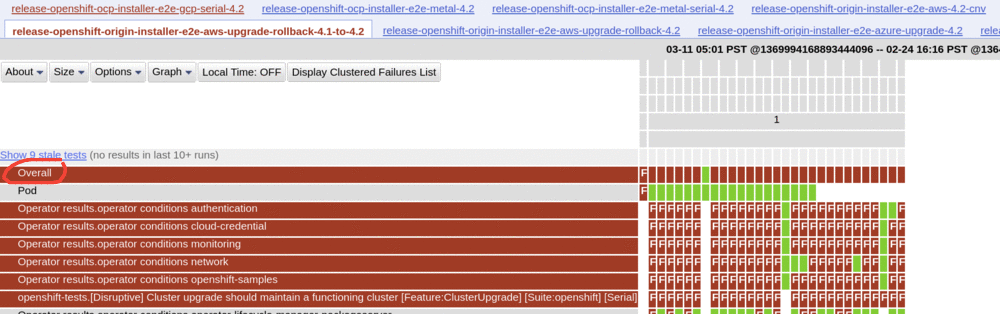

In [58]:
Image(filename="../../../docs/assets/images/testgrid_03.png")